<a href="https://colab.research.google.com/github/KfirBernstein/kaggle_email_spam/blob/main/kaggke_spam_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Email Spam Dataset - Feature Engineering and EDA**


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


**Load & Clean Dataset**

In [11]:
url = 'https://raw.githubusercontent.com/KfirBernstein/kaggle_email_spam/main/emails.csv'
dataset = pd.read_csv(url)
dataset['parsed_text'] = dataset['text'].apply(lambda x: x.split('Subject: ')[1])
dataset.head()

,text,spam,parsed_text
0,Subject: naturally irresistible your corporate...,1,naturally irresistible your corporate identity...
1,Subject: the stock trading gunslinger fanny i...,1,the stock trading gunslinger fanny is merrill...
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting t...
3,Subject: 4 color printing special request add...,1,4 color printing special request additional i...
4,"Subject: do not have money , get software cds ...",1,"do not have money , get software cds from here..."


In [37]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
tqdm.pandas()
dataset['tokenized_text'] = dataset['parsed_text'].apply(lambda x: word_tokenize(x))
stop_words_set = set(stopwords.words('english'))
dataset['filtered_text'] = dataset['tokenized_text'].progress_apply(lambda x: [word for word in x if word.lower() not in stop_words_set and word not in [',', '.']])

dataset.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/5728 [00:00<?, ?it/s]

,text,spam,parsed_text,tokenized_text,filtered_text
0,Subject: naturally irresistible your corporate...,1,naturally irresistible your corporate identity...,"[naturally, irresistible, your, corporate, ide...","[naturally, irresistible, corporate, identity,..."
1,Subject: the stock trading gunslinger fanny i...,1,the stock trading gunslinger fanny is merrill...,"[the, stock, trading, gunslinger, fanny, is, m...","[stock, trading, gunslinger, fanny, merrill, m..."
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting t...,"[unbelievable, new, homes, made, easy, im, wan...","[unbelievable, new, homes, made, easy, im, wan..."
3,Subject: 4 color printing special request add...,1,4 color printing special request additional i...,"[4, color, printing, special, request, additio...","[4, color, printing, special, request, additio..."
4,"Subject: do not have money , get software cds ...",1,"do not have money , get software cds from here...","[do, not, have, money, ,, get, software, cds, ...","[money, get, software, cds, !, software, compa..."


**WordCloud**

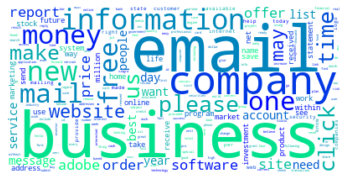

In [39]:
from wordcloud import WordCloud
import itertools

word_cloud = WordCloud(background_color='white', colormap='winter', collocations=False)
list_of_words = list(itertools.chain(*[sentence for sentence in dataset[dataset.spam == 1]['filtered_text']]))
word_cloud.generate(','.join(list_of_words))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

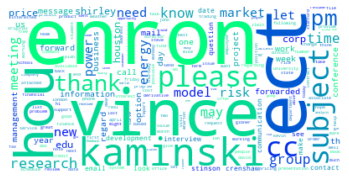

In [40]:
list_of_words = list(itertools.chain(*[sentence for sentence in dataset[dataset.spam == 0]['filtered_text']]))
word_cloud.generate(','.join(list_of_words))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


**Small Feature Engineering**

In [ ]:
my_spam_words = ['free', 'new', 'million', 'ect']
features = pd.DataFrame()
features['words_count'] = dataset['parsed_text'].apply(lambda x: len(x.split(' ')))
for spam_word in my_spam_words:
  features[f'{spam_word}_count'] = dataset['parsed_text'].apply(lambda x: x.count(spam_word))


dataset['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

**Bert sentence embeddings**

In [ ]:
!pip install sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
from tqdm import tqdm
embeddings = []
for text in tqdm(dataset['parsed_text']):

  sentence_embeddings = sbert_model.encode(text)
  embeddings.append(sentence_embeddings)
len(embeddings)

100%|██████████| 5728/5728 [45:36<00:00,  2.09it/s]


5728

**Tabular Feature Distribution Plots**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

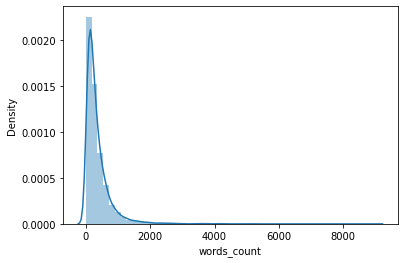

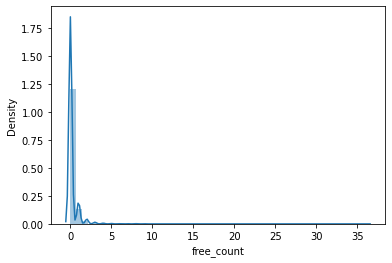

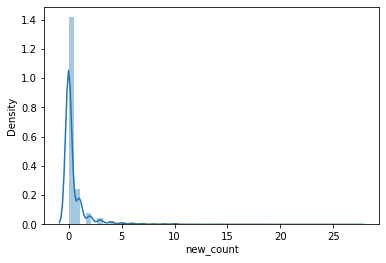

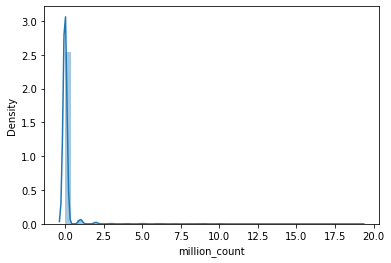

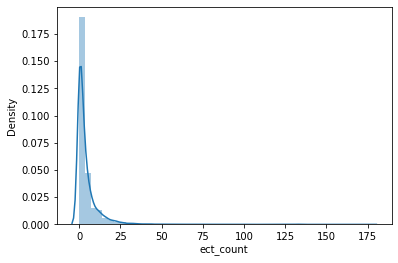

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for i, col in enumerate(features.columns):
  plt.figure(i)
  sns_plot = sns.distplot(features[col])



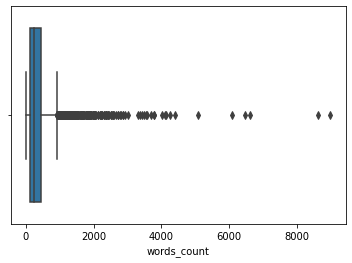

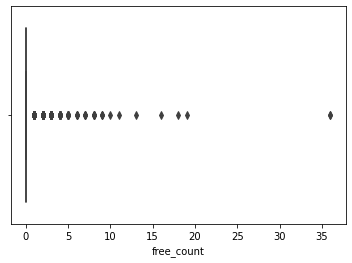

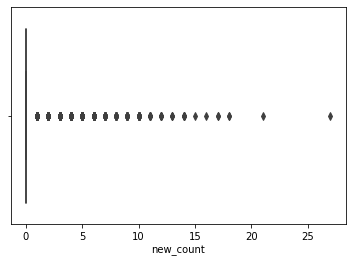

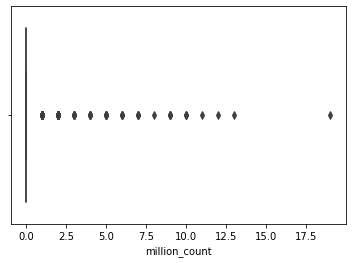

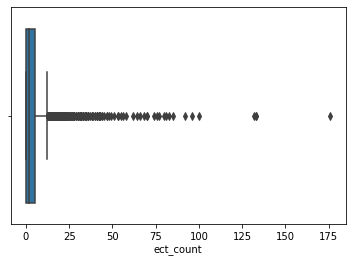

In [ ]:
for i, col in enumerate(features.columns):
  plt.figure(i)
  sns.boxplot(x = features[col])

**Embeddings Dim Reduction Plots**

In [ ]:
values = np.column_stack(embeddings).T
columns = [f'vec_{i}' for i in range(values.shape[1])]
embeddings_dataframe = pd.DataFrame(values, dataset.index, columns)


In [ ]:
def plot_3dim_reduction(res, y):
  pos = res[y == 1]
  neg = res[y == 0]
  ax = plt.figure().gca(projection = '3d')
  ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],color='blue')
  ax.scatter(neg[:, 0], neg[:, 1], neg[:, 2],color='red')
  plt.show()

**PCA**

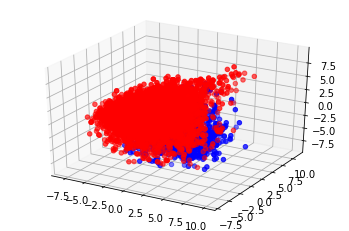

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_res = pca.fit_transform(embeddings_dataframe)

plot_3dim_reduction(pca_res, dataset['spam'])

**T-SNE**

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000)
tsne_res = tsne.fit_transform(embeddings_dataframe)



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5728 samples in 0.006s...
[t-SNE] Computed neighbors for 5728 samples in 3.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5728
[t-SNE] Computed conditional probabilities for sample 2000 / 5728
[t-SNE] Computed conditional probabilities for sample 3000 / 5728
[t-SNE] Computed conditional probabilities for sample 4000 / 5728
[t-SNE] Computed conditional probabilities for sample 5000 / 5728
[t-SNE] Computed conditional probabilities for sample 5728 / 5728
[t-SNE] Mean sigma: 3.008415
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.007095
[t-SNE] KL divergence after 1000 iterations: 1.919319


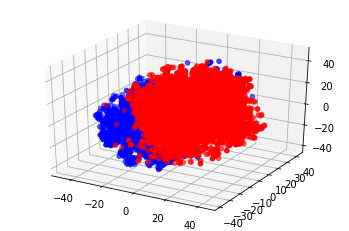

In [ ]:
plot_3dim_reduction(tsne_res, dataset['spam'])

In [ ]:
pip install umap-learn

**UMAP**

In [ ]:
import umap.umap_ as umap
u_map = umap.UMAP(min_dist=0.1, n_epochs=1000, n_components=3, n_neighbors=5)
umap_res = u_map.fit_transform(embeddings_dataframe)


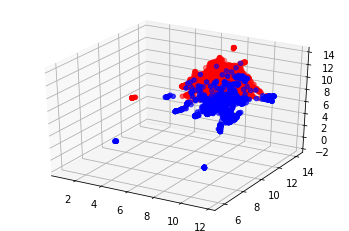

In [ ]:
plot_3dim_reduction(umap_res, dataset['spam'])

**Tabular Feature Importance**

**Mutual Information**

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mutual_info_val = mutual_info_classif(features, dataset['spam'])
feature_importance = {k: mutual_info_val[i] for i,k in enumerate(features.columns)}
feature_importance

{'ect_count': 0.05718087226503954,
 'free_count': 0.010740185347758446,
 'million_count': 0.013852909469385999,
 'new_count': 0.0,
 'words_count': 0.05905621652200299}

**Pearson's Correlation**

In [ ]:
from scipy.stats import pearsonr

feature_importance = {k: pearsonr(features[k], dataset['spam'])[0] for i,k in enumerate(features.columns)}

feature_importance


{'ect_count': -0.18018235395031906,
 'free_count': 0.14772643393611018,
 'million_count': 0.12043743390151405,
 'new_count': 0.030946807853074892,
 'words_count': -0.08568725943596729}

**Spearman Correlation**

In [ ]:
from scipy.stats import spearmanr

feature_importance = {k: spearmanr(features[k], dataset['spam'])[0] for i,k in enumerate(features.columns)}

feature_importance

{'ect_count': -0.30330748958468295,
 'free_count': 0.11734108670834299,
 'million_count': 0.16532675662514967,
 'new_count': 0.03618691078672803,
 'words_count': -0.1964368727494442}

**Pearson's Correlation between the variables**

In [ ]:
features.corr()

,words_count,free_count,new_count,million_count,ect_count
words_count,1.000000,0.300962,0.486834,0.469598,0.590375
free_count,0.300962,1.000000,0.205176,0.256923,0.030621
new_count,0.486834,0.205176,1.000000,0.302295,0.202168
million_count,0.469598,0.256923,0.302295,1.000000,0.169564
ect_count,0.590375,0.030621,0.202168,0.169564,1.000000
